# Kaggle - How Much Did It Rain? II

Please download the following two files from Kaggle's [How Much Did It Rain? II](https://www.kaggle.com/c/how-much-did-it-rain-ii/) page. You will need to signup to a free Kaggle account if you don't have one yet.

The files you need are:

- train.zip
- test.zip

Kaggle's [description](https://www.kaggle.com/c/how-much-did-it-rain-ii/data) of the data:

> To understand the data, you have to realize that there are multiple radar observations over the course of an hour, and only one gauge observation (the 'Expected'). That is why there are multiple rows with the same 'Id'.

The columns in the datasets are:

Column | Description
-----: | :----------
Id | A unique number for the set of observations over an hour at a gauge.
minutes_past | For each set of radar observations, the minutes past the top of the hour that the radar observations were carried out.  Radar observations are snapshots at that point in time.
radardist_km | Distance of gauge from the radar whose observations are being reported.
Ref | Radar reflectivity in km
Ref_5x5_10th | 10th percentile of reflectivity values in 5x5 neighborhood around the gauge.
Ref_5x5_50th | 50th percentile
Ref_5x5_90th | 90th percentile
RefComposite | Maximum reflectivity in the vertical column above gauge.  In dBZ.
RefComposite_5x5_10th |
RefComposite_5x5_50th |
RefComposite_5x5_90th |
RhoHV | Correlation coefficient (unitless)
RhoHV_5x5_10th |
RhoHV_5x5_50th |
RhoHV_5x5_90th |
Zdr | Differential reflectivity in dB
Zdr_5x5_10th |
Zdr_5x5_50th |
Zdr_5x5_90th |
Kdp | Specific differential phase (deg/km)
Kdp_5x5_10th |
Kdp_5x5_50th |
Kdp_5x5_90th |
Expected | Actual gauge observation in mm at the end of the hour.

In [2]:
import os
import random
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
import numpy as np

from tensorflow.contrib.rnn import GRUCell
from tensorflow.contrib.layers import batch_norm, fully_connected, variance_scaling_initializer
from tensorflow.contrib.learn import extract_pandas_data, extract_pandas_labels

The training and test data must exist before we can continue:

In [3]:
assert os.path.isfile('train.csv')

Import the training data:

In [3]:
df = pd.read_csv('train.csv')

Quickly have a look at the data:

In [5]:
df.head(18)  # The first 18 rows contain all measurements for Id's 1 and 2.

,Id,minutes_past,radardist_km,Ref,Ref_5x5_10th,Ref_5x5_50th,Ref_5x5_90th,RefComposite,RefComposite_5x5_10th,RefComposite_5x5_50th,...,RhoHV_5x5_90th,Zdr,Zdr_5x5_10th,Zdr_5x5_50th,Zdr_5x5_90th,Kdp,Kdp_5x5_10th,Kdp_5x5_50th,Kdp_5x5_90th,Expected
0,1,3,10.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.254
1,1,16,10.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.254
2,1,25,10.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.254
3,1,35,10.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.254
4,1,45,10.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.254
5,1,55,10.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.254
6,2,1,2.0,9.0,5.0,7.5,10.5,15.0,10.5,16.5,...,0.998333,0.3750,-0.1250,0.3125,0.8750,1.059998,-1.410004,-0.350006,1.059998,1.016
7,2,6,2.0,26.5,22.5,25.5,31.5,26.5,26.5,28.5,...,1.005000,0.0625,-0.1875,0.2500,0.6875,NaN,NaN,NaN,1.409988,1.016
8,2,11,2.0,21.5,15.5,20.5,25.0,26.5,23.5,25.0,...,1.001667,0.3125,-0.0625,0.3125,0.6250,0.349991,NaN,-0.350006,1.759994,1.016
9,2,16,2.0,18.0,14.0,17.5,21.0,20.5,18.0,20.5,...,1.001667,0.2500,0.1250,0.3750,0.6875,0.349991,-1.059998,0.000000,1.059998,1.016


In [6]:
df.shape

(13765201, 24)

In [7]:
df.describe()

,Id,minutes_past,radardist_km,Ref,Ref_5x5_10th,Ref_5x5_50th,Ref_5x5_90th,RefComposite,RefComposite_5x5_10th,RefComposite_5x5_50th,...,RhoHV_5x5_90th,Zdr,Zdr_5x5_10th,Zdr_5x5_50th,Zdr_5x5_90th,Kdp,Kdp_5x5_10th,Kdp_5x5_50th,Kdp_5x5_90th,Expected
count,1.376520e+07,1.376520e+07,1.376520e+07,6.349375e+06,5.283988e+06,6.356482e+06,7.551281e+06,6.716343e+06,5.755673e+06,6.711663e+06,...,5.905584e+06,4.934916e+06,4.133154e+06,4.936568e+06,5.905584e+06,4.182635e+06,3.428782e+06,4.187281e+06,5.052776e+06,1.376520e+07
mean,5.923370e+05,2.952373e+01,1.106794e+01,2.292666e+01,1.995227e+01,2.261029e+01,2.589846e+01,2.471108e+01,2.215824e+01,2.442075e+01,...,1.015272e+00,5.367092e-01,-7.190076e-01,3.376216e-01,2.072870e+00,3.545172e-02,-3.482325e+00,-4.736553e-01,4.079836e+00,1.086263e+02
std,3.408561e+05,1.730813e+01,4.206618e+00,1.035516e+01,9.208166e+00,1.005300e+01,1.110958e+01,1.068962e+01,9.702705e+00,1.042453e+01,...,4.861606e-02,1.510399e+00,1.006068e+00,9.386440e-01,1.670194e+00,3.869725e+00,2.792120e+00,2.263046e+00,4.147337e+00,5.486058e+02
min,1.000000e+00,0.000000e+00,0.000000e+00,-3.100000e+01,-3.200000e+01,-3.200000e+01,-2.850000e+01,-3.200000e+01,-3.100000e+01,-2.750000e+01,...,2.083333e-01,-7.875000e+00,-7.875000e+00,-7.875000e+00,-7.875000e+00,-9.604000e+01,-8.079000e+01,-7.877000e+01,-1.002000e+02,1.000000e-02
25%,2.968970e+05,1.500000e+01,9.000000e+00,1.600000e+01,1.400000e+01,1.600000e+01,1.800000e+01,1.750000e+01,1.600000e+01,1.750000e+01,...,9.983333e-01,-1.875000e-01,-1.125000e+00,-6.250000e-02,1.062500e+00,-1.410004e+00,-4.580002e+00,-7.100067e-01,2.069992e+00,2.540001e-01
50%,5.921990e+05,3.000000e+01,1.100000e+01,2.250000e+01,2.000000e+01,2.250000e+01,2.550000e+01,2.400000e+01,2.200000e+01,2.400000e+01,...,1.011667e+00,3.750000e-01,-6.250000e-01,2.500000e-01,1.687500e+00,0.000000e+00,-2.820007e+00,0.000000e+00,3.519989e+00,1.016000e+00
75%,8.895820e+05,4.400000e+01,1.400000e+01,2.950000e+01,2.600000e+01,2.900000e+01,3.350000e+01,3.150000e+01,2.850000e+01,3.150000e+01,...,1.051667e+00,1.062500e+00,-1.875000e-01,6.875000e-01,2.625000e+00,1.750000e+00,-1.760010e+00,3.499908e-01,5.639999e+00,3.810002e+00
max,1.180945e+06,5.900000e+01,2.100000e+01,7.100000e+01,6.250000e+01,6.900000e+01,7.250000e+01,9.250000e+01,6.600000e+01,7.100000e+01,...,1.051667e+00,7.937500e+00,7.937500e+00,7.937500e+00,7.937500e+00,1.797500e+02,3.519989e+00,1.280000e+01,1.446000e+02,3.301773e+04


In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13765201 entries, 0 to 13765200
Data columns (total 24 columns):
Id                       int64
minutes_past             int64
radardist_km             float64
Ref                      float64
Ref_5x5_10th             float64
Ref_5x5_50th             float64
Ref_5x5_90th             float64
RefComposite             float64
RefComposite_5x5_10th    float64
RefComposite_5x5_50th    float64
RefComposite_5x5_90th    float64
RhoHV                    float64
RhoHV_5x5_10th           float64
RhoHV_5x5_50th           float64
RhoHV_5x5_90th           float64
Zdr                      float64
Zdr_5x5_10th             float64
Zdr_5x5_50th             float64
Zdr_5x5_90th             float64
Kdp                      float64
Kdp_5x5_10th             float64
Kdp_5x5_50th             float64
Kdp_5x5_90th             float64
Expected                 float64
dtypes: float64(22), int64(2)
memory usage: 2.5 GB


We have 24 columns, of which one is the Id of the group of measurements falling in the same hour, and one is the Exptected value. So in effect we are left with **22 features**.

## Frame the problem

From Kaggle:

> You are given snapshots of polarimetric radar values and asked to predict the hourly rain gauge total.

So we have a **regression** problem here, a **multivariate** one at that, since we have more than one input.

> To understand the data, you have to realize that there are multiple radar observations over the course of an hour, and only one gauge observation (the 'Expected').

It is a **supervised learning** task, since the _target_ or _label_ is provided for us. And since each instance consists of multiple observations over the course of an hour, each instance is a time series and drives us to looking into Recurrent Neural Networks (RNN).

> The evaluation metric for this competition is Mean Absolute Error (MAE)

Ok, that's a given. The MAE is defined as:

\begin{equation*}
MAE = \frac{1}{m} \sum_{i=1}^{m} \vert y_{i} - \hat{y_{i}} \vert
\end{equation*}

Note:

> A word of caution: many of the gauge values in the training dataset are implausible (gauges may get clogged, for example)

We'll have to see whether we can leave these values in or whether we'll have to first find a way to filter them out.

## Visualize the data

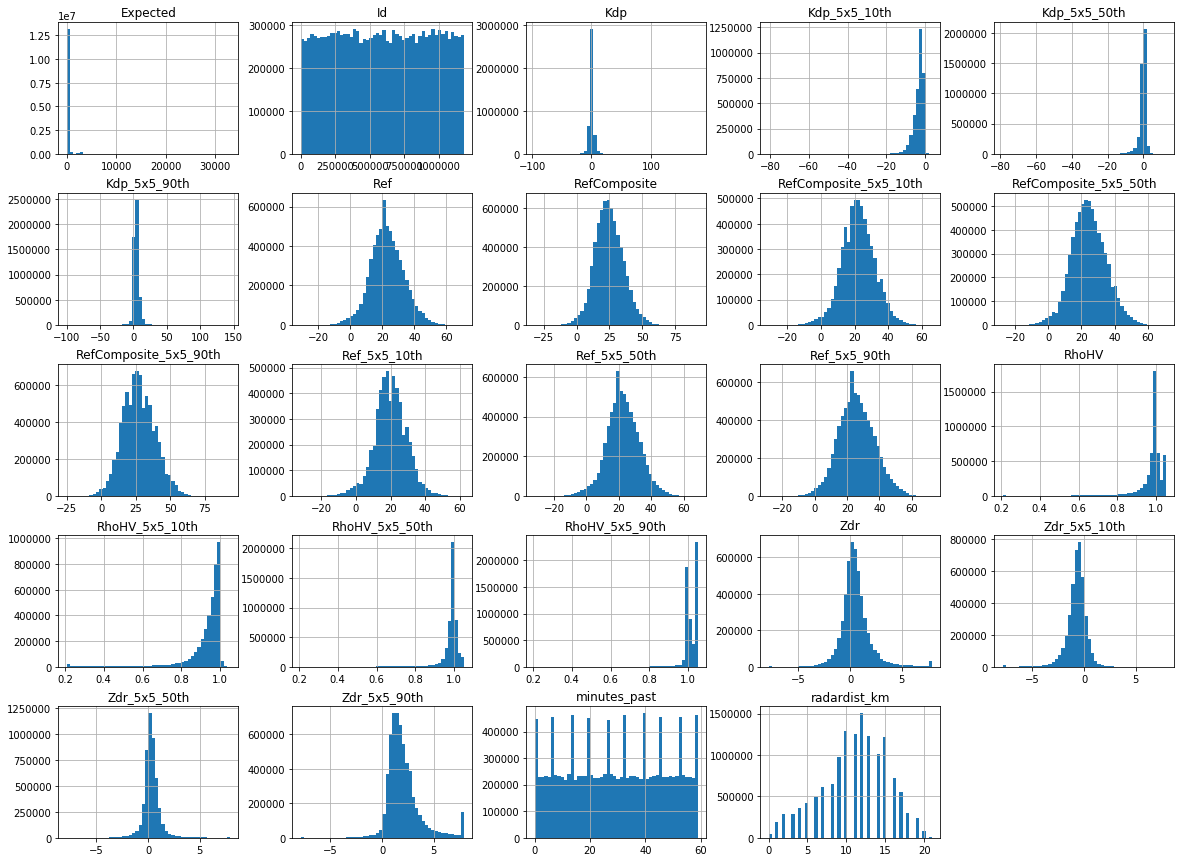

In [9]:
%matplotlib inline
df.hist(bins=50, figsize=(20,15))
plt.show()

## Prepare the data

The distribution of expected rain in milimeters seems off, as warned about. The maximum value of about 30,000 millimeters means that _30 meters_ of rain would have fallen in that hour. Better call Noah to build us a boat...

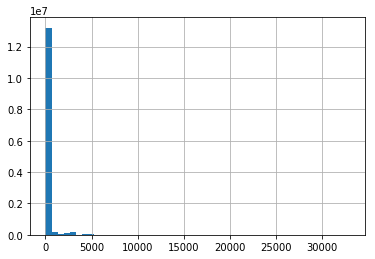

In [10]:
df['Expected'].hist(bins=50)
plt.show()

Since there are multiple radar observations per hour, and all of these have the same values for Id and Expected, we can first simplify the histogram by taking only the first Expected value (`head(1)`) per Id (`groupby('Id')`) into account. That is what we do here:

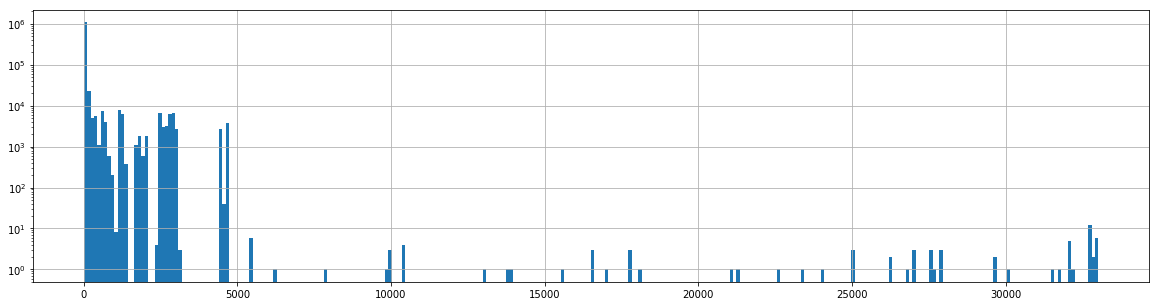

In [11]:
# Plot it logarithmically so that we can still make out Expected values
# that do not occur that often.
_, ax = plt.subplots()
df.groupby('Id').head(1)['Expected'].hist(ax=ax, bins=300,figsize=(20,5))
ax.set_yscale('log')
plt.show()

We can see that the largest peak in expected rain is close to zero mm's, and that the majority of rain is less than 5,000 mm per hour. This is still five meters of rain, but maybe that's realistic, I have no idea.

This is followed by some lone wolves of more than 5,000 mm of rain per hour. Since these values are so dispersed over the range, it is likely these our outliers caused by clogged gauges, and we can simply discard these measurements.

In [4]:
df = df[df['Expected'] < 5000]

Some cells have no values ("NaN", or Not a Number). There are [various ways](http://pandas.pydata.org/pandas-docs/stable/missing_data.html) we can handle missing data.

The simplest thing to do would be to discard instances containing one or more of such cells, but if there are quite many of them, then maybe we want to keep them but replace them by, for instance, the median across all those cells.

How many rows have at least one NaN?

In [13]:
df.isnull().any(axis=1).sum()

10995356

So 10,995,356 out of 13,765,201 rows have at least one NaN. Throwing away such rows completely is therefore out of the question. Yes, we'd still have some 3,000,000 rows of data, but we'd also throw away some 80% of the training set.

Let's simply replace such NaN values by the **mean** of their columns:

In [5]:
df = df.fillna(df.mean())

## Batch Normalization

Let's look at the spread of the features we have:

In [15]:
for column in df.columns.difference(['Id', 'Expected']):
    print('{:<25}  {:8.3f}  {:8.3f}'.format(
        column,
        df[column].min(),
        df[column].max()))

Kdp                         -96.040   179.750
Kdp_5x5_10th                -80.790     3.520
Kdp_5x5_50th                -78.770    12.800
Kdp_5x5_90th               -100.200   144.600
Ref                         -31.000    71.000
RefComposite                -32.000    92.500
RefComposite_5x5_10th       -31.000    66.000
RefComposite_5x5_50th       -27.500    71.000
RefComposite_5x5_90th       -25.000    93.500
Ref_5x5_10th                -32.000    62.500
Ref_5x5_50th                -32.000    69.000
Ref_5x5_90th                -28.500    72.500
RhoHV                         0.208     1.052
RhoHV_5x5_10th                0.208     1.052
RhoHV_5x5_50th                0.208     1.052
RhoHV_5x5_90th                0.208     1.052
Zdr                          -7.875     7.938
Zdr_5x5_10th                 -7.875     7.938
Zdr_5x5_50th                 -7.875     7.938
Zdr_5x5_90th                 -7.875     7.938
minutes_past                  0.000    59.000
radardist_km                  0.00

They are spread quite a bit, with Kdp from -96 to +179, and RhoHV from 0.2 to 1, for example. We'll use **batch normalization** to center all input features around zero and normalize them.

## Sequence Length

Remember that radar measurements are taken a number of times per hour, and all these together carry the same Id. One such group makes up a **time-series** for our recurrent network.

Let's look at the distribution of the lenghts of these time series:

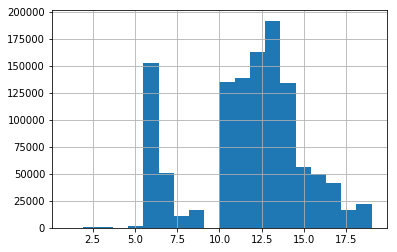

In [16]:
group_sizes = df.groupby('Id').size()
group_sizes.hist(bins=20)

In [17]:
group_sizes.min(), group_sizes.max()

(1, 19)

So some hourly groups consist of only one sample, and some as many as 19. This means our time series will be of variable length and we'll have to take care of this.

## Batching Pandas DataFrame into TensorFlow

All training and test data is contained in a Pandas DataFrame referenced by `df`. To train our model in TensorFlow, we'll have to extract the features (aka _predictors_ or simply the columns) as well as the labels (or _targets_).

In [25]:
class RowSequence:
    def __init__(self, first=None, last=None):
        self.first = first
        self.last  = last
    
class Batcher:
    def __init__(self, df, batch_size=50):
        self._df                = df
        self._batch_size        = batch_size
        self._group_number2rows = self.group_measurements()
        self._group_numbers     = list(self._group_number2rows.keys())
        self._group_index       = 0

    def group_measurements(self):
        d = dict()
        for idx, group_id in df['Id'].iteritems():
            if not group_id in d.keys():
                d[group_id] = RowSequence(first=idx)
            else:
                d[group_id].last = idx
        return d

    def reset(self):
        """Shuffles all measurement indexes and start over."""
        random.shuffle(self._group_numbers)
        self._group_index = 0

    def next_batch(self):
        """Returns a random group of (features, labels) of length batch_size."""
        features, labels = [], []
        for i in range(self._batch_size):
            seq = self._group_number2rows[self._group_numbers[self._group_index]]
            self._group_index += 1
            rows = df[seq.first:seq.last]
            features.append(rows[rows.columns.difference(['Id', 'Expected'])])
            labels.append(rows['Expected'])
        return features, labels
    
    def batch_count(self):
        """Returns the total number of batches."""
        return self._df.shape[0] // self._batch_size

## Build a First Model

In [30]:
n_steps   = 19   # Longest input sequence is 19 measurements in one hour.
n_inputs  = 22   # Data consists of 22 features.
n_neurons = 100  # Have to start somewhere.
n_outputs = 1    # Regression task: predict fallen rain in mm.

Build the network:

In [31]:
tf.reset_default_graph()

X          = tf.placeholder(tf.float32, [None, n_steps, n_inputs])
y          = tf.placeholder(tf.float32, [None, n_steps, n_outputs])
seq_length = tf.placeholder(tf.int32, [None])

is_training = tf.placeholder(tf.bool, [], name='is_training')
batch_norm_params = {
    'is_training': is_training,
    'decay': 0.99,
    'updates_collections': None
}

# Use He-initialization for the weights to prevent vanishing/exploding gradients.
he_init = variance_scaling_initializer()

# The core the network is a set of Gated Recurrent Unit (GRU) cells, a simpler but
# equally efficient variant of the Long Short-Term Memory (LSTM) cell.
cell                = GRUCell(num_units=n_neurons, kernel_initializer=he_init, activation=tf.nn.relu)
rnn_outputs, states = tf.nn.dynamic_rnn(cell, X, dtype=tf.float32, sequence_length=seq_length)

# The GRU cell has #n_neurons outputs, and we need to map these onto one output for
# our regression problem, to predict the amount of fallen rain. We use a fully connected
# layer to do so, but we'll have to reshape its inputs and outputs.
stacked_rnn_outputs = tf.reshape(rnn_outputs, [-1, n_neurons])
stacked_outputs     = fully_connected(
    stacked_rnn_outputs,
    n_outputs,
    normalizer_fn=batch_norm,
    normalizer_params=batch_norm_params,
    activation_fn=None)
outputs = tf.reshape(stacked_outputs, [-1, n_steps, n_outputs])

learning_rate = 0.001

# The loss function is the requested Mean Average Error (MAE).
loss        = tf.reduce_mean(outputs - y)
optimizer   = tf.train.AdamOptimizer(learning_rate=learning_rate)
training_op = optimizer.minimize(loss)

init = tf.global_variables_initializer()

Create a batcher only once, since it's expensive:

In [53]:
batcher = Batcher(df)

Let's run the model:

In [55]:
n_epochs = 1

with tf.Session() as sess:
    init.run()
    
    for epoch in range(n_epochs):
        for iteration in range(batcher.batch_count()):
            X_batch, y_batch = batcher.next_batch()
            print('X={} y={}'.format(len(X_batch), len(y_batch)))
            # sess.run(training_op, feed_dict={X: X_batch, y: y_batch, seq_length: seq_length_batch}

X=50 y=50
X=50 y=50
X=50 y=50
X=50 y=50
X=50 y=50
X=50 y=50
X=50 y=50
X=50 y=50
X=50 y=50
X=50 y=50
X=50 y=50
X=50 y=50
X=50 y=50
X=50 y=50
X=50 y=50
X=50 y=50
X=50 y=50
X=50 y=50
X=50 y=50
X=50 y=50
X=50 y=50
X=50 y=50
X=50 y=50
X=50 y=50
X=50 y=50
X=50 y=50
X=50 y=50
X=50 y=50
X=50 y=50
X=50 y=50
X=50 y=50
X=50 y=50
X=50 y=50
X=50 y=50
X=50 y=50
X=50 y=50
X=50 y=50
X=50 y=50
X=50 y=50
X=50 y=50
X=50 y=50
X=50 y=50
X=50 y=50
X=50 y=50
X=50 y=50
X=50 y=50
X=50 y=50
X=50 y=50
X=50 y=50
X=50 y=50
X=50 y=50
X=50 y=50
X=50 y=50
X=50 y=50
X=50 y=50
X=50 y=50
X=50 y=50
X=50 y=50
X=50 y=50
X=50 y=50
X=50 y=50
X=50 y=50
X=50 y=50
X=50 y=50
X=50 y=50
X=50 y=50
X=50 y=50
X=50 y=50
X=50 y=50
X=50 y=50
X=50 y=50
X=50 y=50
X=50 y=50
X=50 y=50
X=50 y=50
X=50 y=50
X=50 y=50
X=50 y=50
X=50 y=50
X=50 y=50
X=50 y=50
X=50 y=50
X=50 y=50
X=50 y=50
X=50 y=50
X=50 y=50
X=50 y=50
X=50 y=50
X=50 y=50
X=50 y=50
X=50 y=50
X=50 y=50
X=50 y=50
X=50 y=50
X=50 y=50
X=50 y=50
X=50 y=50
X=50 y=50
X=50 y=50
X=50 y=50


KeyError: 18381

In [56]:
batcher.batch_count()

23617

In [57]:
23617*50

1180850

In [59]:
len(batcher._labels)

13764417

In [74]:
len(batcher._features)

13764417

In [69]:
batcher._labels[18380]

2084.8332999999998

In [70]:
batcher._labels[18381]

KeyError: 18381

In [75]:
batcher._features[18381]

array([  0.03545802,  -3.48231648,  -0.47365933,   4.07982698,
        22.92673284,  24.71117217,  22.15833853,  24.4208435 ,
        27.36907904,  19.95236179,  22.6103656 ,  25.8985703 ,
         0.97289067,   0.91886023,   0.97440059,   1.01527219,
         0.53669381,  -0.71901424,   0.337608  ,   2.07284723,
         1.        ,   5.        ])

In [79]:
df[:1]

,Id,minutes_past,radardist_km,Ref,Ref_5x5_10th,Ref_5x5_50th,Ref_5x5_90th,RefComposite,RefComposite_5x5_10th,RefComposite_5x5_50th,...,RhoHV_5x5_90th,Zdr,Zdr_5x5_10th,Zdr_5x5_50th,Zdr_5x5_90th,Kdp,Kdp_5x5_10th,Kdp_5x5_50th,Kdp_5x5_90th,Expected
0,1,3,10.0,22.926733,19.952362,22.610366,25.89857,24.711172,22.158339,24.420844,...,1.015272,0.536694,-0.719014,0.337608,2.072847,0.035458,-3.482316,-0.473659,4.079827,0.254


In [108]:
d1 = extract_pandas_data(df['Id'])
d2 = extract_pandas_data(df[df.columns.difference(['Id', 'Expected'])])

In [109]:
len(d1), len(d2)

(13764417, 13764417)

In [110]:
d1[0], d2[0]

(1, array([  0.03545802,  -3.48231648,  -0.47365933,   4.07982698,
         22.92673284,  24.71117217,  22.15833853,  24.4208435 ,
         27.36907904,  19.95236179,  22.6103656 ,  25.8985703 ,
          0.97289067,   0.91886023,   0.97440059,   1.01527219,
          0.53669381,  -0.71901424,   0.337608  ,   2.07284723,
          3.        ,  10.        ]))

In [111]:
df[:1]

,Id,minutes_past,radardist_km,Ref,Ref_5x5_10th,Ref_5x5_50th,Ref_5x5_90th,RefComposite,RefComposite_5x5_10th,RefComposite_5x5_50th,...,RhoHV_5x5_90th,Zdr,Zdr_5x5_10th,Zdr_5x5_50th,Zdr_5x5_90th,Kdp,Kdp_5x5_10th,Kdp_5x5_50th,Kdp_5x5_90th,Expected
0,1,3,10.0,22.926733,19.952362,22.610366,25.89857,24.711172,22.158339,24.420844,...,1.015272,0.536694,-0.719014,0.337608,2.072847,0.035458,-3.482316,-0.473659,4.079827,0.254


In [112]:
df[:10]

,Id,minutes_past,radardist_km,Ref,Ref_5x5_10th,Ref_5x5_50th,Ref_5x5_90th,RefComposite,RefComposite_5x5_10th,RefComposite_5x5_50th,...,RhoHV_5x5_90th,Zdr,Zdr_5x5_10th,Zdr_5x5_50th,Zdr_5x5_90th,Kdp,Kdp_5x5_10th,Kdp_5x5_50th,Kdp_5x5_90th,Expected
0,1,3,10.0,22.926733,19.952362,22.610366,25.89857,24.711172,22.158339,24.420844,...,1.015272,0.536694,-0.719014,0.337608,2.072847,0.035458,-3.482316,-0.473659,4.079827,0.254
1,1,16,10.0,22.926733,19.952362,22.610366,25.89857,24.711172,22.158339,24.420844,...,1.015272,0.536694,-0.719014,0.337608,2.072847,0.035458,-3.482316,-0.473659,4.079827,0.254
2,1,25,10.0,22.926733,19.952362,22.610366,25.89857,24.711172,22.158339,24.420844,...,1.015272,0.536694,-0.719014,0.337608,2.072847,0.035458,-3.482316,-0.473659,4.079827,0.254
3,1,35,10.0,22.926733,19.952362,22.610366,25.89857,24.711172,22.158339,24.420844,...,1.015272,0.536694,-0.719014,0.337608,2.072847,0.035458,-3.482316,-0.473659,4.079827,0.254
4,1,45,10.0,22.926733,19.952362,22.610366,25.89857,24.711172,22.158339,24.420844,...,1.015272,0.536694,-0.719014,0.337608,2.072847,0.035458,-3.482316,-0.473659,4.079827,0.254
5,1,55,10.0,22.926733,19.952362,22.610366,25.89857,24.711172,22.158339,24.420844,...,1.015272,0.536694,-0.719014,0.337608,2.072847,0.035458,-3.482316,-0.473659,4.079827,0.254
6,2,1,2.0,9.000000,5.000000,7.500000,10.50000,15.000000,10.500000,16.500000,...,0.998333,0.375000,-0.125000,0.312500,0.875000,1.059998,-1.410004,-0.350006,1.059998,1.016
7,2,6,2.0,26.500000,22.500000,25.500000,31.50000,26.500000,26.500000,28.500000,...,1.005000,0.062500,-0.187500,0.250000,0.687500,0.035458,-3.482316,-0.473659,1.409988,1.016
8,2,11,2.0,21.500000,15.500000,20.500000,25.00000,26.500000,23.500000,25.000000,...,1.001667,0.312500,-0.062500,0.312500,0.625000,0.349991,-3.482316,-0.350006,1.759994,1.016
9,2,16,2.0,18.000000,14.000000,17.500000,21.00000,20.500000,18.000000,20.500000,...,1.001667,0.250000,0.125000,0.375000,0.687500,0.349991,-1.059998,0.000000,1.059998,1.016


In [116]:
df[18381:18381+1]

,Id,minutes_past,radardist_km,Ref,Ref_5x5_10th,Ref_5x5_50th,Ref_5x5_90th,RefComposite,RefComposite_5x5_10th,RefComposite_5x5_50th,...,RhoHV_5x5_90th,Zdr,Zdr_5x5_10th,Zdr_5x5_50th,Zdr_5x5_90th,Kdp,Kdp_5x5_10th,Kdp_5x5_50th,Kdp_5x5_90th,Expected
18387,1744,1,5.0,22.926733,19.952362,22.610366,25.89857,24.711172,22.158339,24.420844,...,1.015272,0.536694,-0.719014,0.337608,2.072847,0.035458,-3.482316,-0.473659,4.079827,151.38408


In [122]:
Batcher(df, 50).batch_count()

275288

In [26]:
batcher = Batcher(df, 5)
d = batcher.group_measurements()
print(batcher.next_batch())
print(batcher.next_batch())
print(batcher.next_batch())

([        Kdp  Kdp_5x5_10th  Kdp_5x5_50th  Kdp_5x5_90th        Ref  \
0  0.035458     -3.482316     -0.473659      4.079827  22.926733   
1  0.035458     -3.482316     -0.473659      4.079827  22.926733   
2  0.035458     -3.482316     -0.473659      4.079827  22.926733   
3  0.035458     -3.482316     -0.473659      4.079827  22.926733   
4  0.035458     -3.482316     -0.473659      4.079827  22.926733   

   RefComposite  RefComposite_5x5_10th  RefComposite_5x5_50th  \
0     24.711172              22.158339              24.420844   
1     24.711172              22.158339              24.420844   
2     24.711172              22.158339              24.420844   
3     24.711172              22.158339              24.420844   
4     24.711172              22.158339              24.420844   

   RefComposite_5x5_90th  Ref_5x5_10th      ...          RhoHV  \
0              27.369079     19.952362      ...       0.972891   
1              27.369079     19.952362      ...       0.972891   


In [28]:
b = batcher.next_batch()

In [29]:
type(b)

tuple

In [46]:
np.asmatrix(b[0][2])

matrix([[  4.199997  ,  -5.5700073 ,   1.050003  ,   5.279999  ,
          24.5       ,  24.5       ,  19.5       ,  25.        ,
          28.5       ,  19.5       ,  25.        ,  28.5       ,
           1.005     ,   0.945     ,   0.99833333,   1.0516667 ,
          -0.1875    ,  -2.125     ,   0.1875    ,   1.1875    ,
           5.        ,  13.        ],
        [ -0.3500061 ,  -2.4700012 ,   0.        ,   1.7599945 ,
          20.        ,  20.        ,  16.        ,  21.5       ,
          31.        ,  16.        ,  21.5       ,  31.        ,
           0.985     ,   0.985     ,   0.995     ,   1.0083333 ,
           0.        ,  -0.5       ,   0.4375    ,   1.        ,
          11.        ,  13.        ],
        [  3.8799896 ,  -3.1699982 ,  -0.3500061 ,   3.8799896 ,
          17.        ,  17.        ,  15.5       ,  17.5       ,
          21.        ,  15.5       ,  17.5       ,  21.        ,
           1.0083333 ,   0.9916667 ,   0.99833333,   1.0083333 ,
           0.3